In [1]:
from sklearn.model_selection import train_test_split, PredefinedSplit
from sklearn.metrics import classification_report,roc_curve, auc
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score,recall_score,precision_recall_curve
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np
import os
from collections import Counter
from datetime import datetime
from sklearn.metrics import make_scorer
from sklearn.utils import resample
import joblib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def specificity_scorer(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity= tn / (tn + fp)
    
    return specificity

specificity_score = make_scorer(specificity_scorer)

def find_optimal_specificity_threshold(y, y_prob, specificity_threshold):
    thresholds = np.linspace(0, 1, 1000)
    specificities = [metrics_no_CI(y, y_prob, t)["Specificity"] for t in thresholds]
    optimal_threshold = thresholds[np.argmax(np.array(specificities) >= specificity_threshold)]
    
    return optimal_threshold

def metrics_no_CI(y_true, y_pred_proba,threshold=0.5,labels = [0,1]):
    #quick function for caltulating metrics without Confidence Intervals 
    
    y_true =y_true.astype(int)
    y_pred = np.where(y_pred_proba > threshold, 1, 0).astype(int)
    metrics = {}

    # Compute all metrics
    metrics['Accuracy'] = round(accuracy_score(y_true, y_pred),4)
    try:
        metrics['AUC'] = round(roc_auc_score(y_true, y_pred_proba),4)
    except:
        metrics['AUC'] = 1.0 #in case there is only 1 class i pred
        
    metrics['F1 Score'] = round(f1_score(y_true, y_pred),4)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred,labels=labels).ravel()
    metrics['Sensitivity'] = round(tp / (tp + fn),4)
    metrics['Specificity'] = round(tn / (tn + fp),4)
    
    return metrics



def compute_metrics(y_true, y_pred_prob, threshold=0.5, n_bootstrap=1000, ci=95):
    # main function used in metric calculation
    
    y_pred = (y_pred_prob > threshold).astype(int)
    
    metrics = {'accuracy': accuracy_score,
               'sensitivity': recall_score,
               'specificity': specificity_scorer,#'auc_roc': roc_auc_score, 
               'f1': f1_score}
    
    #bootstrap CI calculation along metrics
    original_metrics_values = {name: func(y_true, y_pred) for name, func in metrics.items()}
    bootstrap_metrics_values = {name: [] for name in metrics.keys()}
    for _ in range(n_bootstrap):
        y_true_resample, y_pred_resample = resample(y_true, y_pred,stratify=y_true) 
        for name, func in metrics.items():
            bootstrap_metrics_values[name].append(func(y_true_resample, y_pred_resample))
    
    original_metrics_values['auc_roc'] =  roc_auc_score(y_true, y_pred_prob)
    bootstrap_metrics_values['auc_roc'] = []
    for _ in range(n_bootstrap):
        y_true_resample, y_pred_resample = resample(y_true, y_pred_prob,stratify=y_true) 
        bootstrap_metrics_values["auc_roc"].append(roc_auc_score(y_true_resample, y_pred_resample))
    
    
    metrics_ci = {name: {'value': original_metrics_values[name],
                         'ci_lower': np.percentile(values, (100-ci)/2), 
                         'ci_upper': np.percentile(values, ci + (100-ci)/2)} for name, values in bootstrap_metrics_values.items()}
    
    
    #adding confussion matrix
    metrics_ci["confusion_matrix"] = [confusion_matrix(y_true, y_pred)]
    
    #generating df from metrics
    metrics_log ={}
    for metric, value in metrics_ci.items():
                    if metric != "confusion_matrix":
                        metrics_log[f'{metric}'] = round(value['value'],4)
                        metrics_log[f'{metric}_CI'] = [round(value['ci_lower'],4),round(value['ci_upper'],4)]
                    else:
                        metrics_log[f'{metric}'] = value
    metrics_ci = pd.DataFrame.from_dict([metrics_log])
    
    return metrics_ci



In [3]:
def make_MAIN_DATASET(cancer_labels_dict,metadata_classes_col,samples_data_df):
    # data splitting function
    
    new_labels = []
    for class_name in df[metadata_classes_col].values:
            if class_name in cancer_labels_dict.keys():
                new_labels.append(cancer_labels_dict[class_name])
            else:
                new_labels.append("EXCLUDE")

    metadata_cancer_col="is_cancer"
    samples_data_df[metadata_cancer_col] = new_labels
    cancer_df = samples_data_df[samples_data_df[metadata_cancer_col]!="EXCLUDE"]

    train_data = cancer_df[cancer_df['isTraining'] == 1]
    train_data = train_data.drop(info_cols, axis=1)
    test_data = cancer_df[cancer_df['isTest'] == 1]
    test_data_sample_labels = test_data[[metadata_classes_col,"StageGroupped"]]
    test_data = test_data.drop(info_cols, axis=1)
    val_data = cancer_df[cancer_df['isValidation'] == 1]
    val_data = val_data.drop(info_cols, axis=1)

    X_train = train_data.drop('is_cancer', axis=1)
    X_val = val_data.drop('is_cancer', axis=1)
    y_train = train_data['is_cancer'].astype('int')
    y_val = val_data['is_cancer'].astype('int')
    X_test = test_data.drop('is_cancer', axis=1)
    y_test = test_data['is_cancer'].astype('int')
    return X_train, y_train, X_val, y_val, X_test, y_test, test_data_sample_labels


In [4]:
def evaluate_model(model, data, metadata_classes_col, cancer_type="CANCER", stage=None, threshold=0.5,PATH =""):
    print("#####")
    print("cancer_type: ", cancer_type)
    print("stage: ", stage)
    print("\n ")
    data_healthy = data[data[metadata_classes_col] == 'Asymptomatic controls']

    if cancer_type !="CANCER":
        if stage:
            data_cancer  = data[(data[metadata_classes_col] == cancer_type) & (data['StageGroupped'] == stage)]
            prefix = f"{stage}_"
        else:
            data_cancer  = data[data[metadata_classes_col] == cancer_type]
            prefix = ""
    else:
        if stage:
            data_cancer  = data[(data[metadata_classes_col] != 'Asymptomatic controls') & (data['StageGroupped'] == stage)]
            prefix = f"{stage}_"
        else:
            data_cancer  = data[data[metadata_classes_col] != 'Asymptomatic controls']
            prefix = ""
    
    
    data_filtered = pd.concat([data_healthy, data_cancer])
        
        
    data_filtered = data_filtered[(data_filtered["isTest"] == 1)]
    X = data_filtered.drop(['is_cancer', 'isTraining', 'isValidation', 'isTest',"StageGroupped","RealLocation",metadata_classes_col,], axis=1)
    y = data_filtered[metadata_classes_col].map(lambda x: 0 if x == 'Asymptomatic controls' else 1)
    print("Labels for cancer type: ",Counter(y))
    
    y_prob = model.predict_proba(X)[:, 1]
    metrics = compute_metrics(y, y_prob, threshold)
    print(metrics)
    metrics = metrics.add_prefix(f"{prefix}")


    return metrics


    
def train_model(model_name,model_type,model,param_grid,labels_dict,samplesData,random_seed,PATH = ""):
    # train-test function for provided model
    
    print(Counter(samplesData["GroupAlternative"]))
    X_train, y_train, X_val, y_val, X_test, y_test, test_data_sample_labels  = make_MAIN_DATASET(labels_dict,metadata_classes_col,samplesData)
    test_data_sample_labels = samplesData[samplesData["isTest"] == 1]
    test_data_sample_labels = test_data_sample_labels[["RealLocation","GroupAlternative","StageGroupped"]]

    # There is predefined VAL-set so Im using PredefinedSplit() for GridSearcCV()
    X_full_train = pd.concat([X_train, X_val])
    y_full_train = pd.concat([y_train, y_val])

    # Create a list where -1 indicates a training sample and 0 indicates a validation sample
    train_indices = np.full((X_train.shape[0],), -1, dtype=int)
    val_indices = np.full((X_val.shape[0],), 0, dtype=int)
    train_val_fold = np.append(train_indices, val_indices)
    
    # Create the PredefinedSplit
    ps = PredefinedSplit(train_val_fold)
    
    
    model = model
    grid_search = GridSearchCV(model, param_grid, cv=ps,scoring="roc_auc") #scoring na roc_auc?
    grid_search.fit(X_full_train, y_full_train)
    print("")
    best_model =grid_search.best_estimator_
    best_params = grid_search.best_params_
    joblib.dump(grid_search.best_estimator_, PATH +model_name+'.pkl')
    

    ### ROC curves
    # Train
    train_pred_proba = best_model.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, train_pred_proba)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Validation
    val_pred_proba = best_model.predict_proba(X_val)[:, 1]
    fpr_val, tpr_val, _ = roc_curve(y_val, val_pred_proba)
    roc_auc_val = auc(fpr_val, tpr_val)

    # Test
    test_data_pred_proba = best_model.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, test_data_pred_proba)
    roc_auc_test = roc_auc_score(y_test, test_data_pred_proba)

    # Plot the ROC curves
    plt.figure(figsize=(10, 8))
    plt.plot(fpr_train, tpr_train, linestyle='--', lw=2, label=f'Train ROC curve (area = {roc_auc_train:.2f})')
    plt.plot(fpr_val, tpr_val, linestyle=':', lw=2, label=f'Validation ROC curve (area = {roc_auc_val:.2f})')
    plt.plot(fpr_test, tpr_test, lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Train, Validation, and Test Sets')
    plt.legend(loc="lower right")
    plt.grid(True)

    # Save the figure
    plt.savefig(PATH + f'{model_name}_roc_curves.png', dpi=300)
    plt.savefig(PATH + f'{model_name}_roc_curves.svg', dpi=300)
    ### end ROC curves
    


    
    model_metadata = pd.DataFrame({
        #"Run Name": [run_name],
        "Random Seed": [random_seed],
        "Model Name": [model_name],
        "Model Type": [model_type],
        "Best Parameters": [str(best_params)]
    })
    specificity_threshold = 0.99
    #metrics_healthy_vs_cancer = compute_metrics(y_test, test_data_pred)
    optimal_threshold = find_optimal_specificity_threshold(y_test, test_data_pred_proba,specificity_threshold)
    metrics_healthy_vs_cancer = compute_metrics(y_test, test_data_pred_proba, optimal_threshold)
    metrics_healthy_vs_cancer = pd.concat([model_metadata, metrics_healthy_vs_cancer], axis=1)
    print(metrics_healthy_vs_cancer)
    
    ### per-stage evaluation
    stages = Counter(test_data_sample_labels["StageGroupped"])
    for stage in stages:
        print("#######################################################")
        # evaluate_model(best_model, samplesData, "GroupAlternative", cancer_type,model_metadata=model_metadata, PATH = PATH)
        metrics_df = evaluate_model(best_model, samplesData, "GroupAlternative", stage=stage,threshold = optimal_threshold,  PATH = PATH)
        metrics_healthy_vs_cancer = pd.concat([metrics_healthy_vs_cancer, metrics_df], axis=1)

     # Append the combined metrics dataframe to the xlsx file
    append_to_xlsx(metrics_healthy_vs_cancer, PATH + f"healthy_vs_cancer_metrics.xlsx")

    
    ### per-cancer-type evaluation
    cancer_types = ['Glioma',
             'Non-small-cell lung cancer',
             'Pancreatic cancer',
             'Breast cancer',
             'Head and neck cancer',
             'Melanoma',
             'Ovarian cancer',
             'Colorectal cancer',
             'Multiple Myeloma',
             'Cholangiocarcinoma',
             'Hepatocellular carcinoma',
             'Endometrial cancer',
             'Esophageal carcinoma',
             'Lymphoma',
             'Prostate cancer',
             'Renal cell cancer',
             'Urothelial cancer',
             "Symptomatic_control"]
    # Create an empty list to store metrics dataframes
    all_metrics = pd.DataFrame()

    for cancer_type in cancer_types:
        print("#######################################################")
       # evaluate_model(best_model, samplesData, "GroupAlternative", cancer_type,model_metadata=model_metadata, PATH = PATH)
        metrics_df = evaluate_model(best_model, samplesData, "GroupAlternative",cancer_type=cancer_type,threshold = optimal_threshold,  PATH = PATH)
        all_metrics = pd.concat([all_metrics, metrics_df], axis=1)
        stages = Counter(test_data_sample_labels[test_data_sample_labels["GroupAlternative"]==cancer_type]["StageGroupped"])
        for stage in stages.keys():

            # Get the metric dataframe for the current stage and append to list
            metrics_stage_df = evaluate_model(best_model, samplesData, "GroupAlternative", cancer_type=cancer_type,threshold = optimal_threshold, stage=stage,PATH= PATH)
            all_metrics = pd.concat([all_metrics, metrics_stage_df], axis=1)
            
        # Combine all the metrics dataframes
        metrics_combined = pd.concat([model_metadata, all_metrics], axis=1)

        # Append the combined metrics dataframe to the xlsx file
        append_to_xlsx(metrics_combined, PATH + f"{cancer_type}_metrics.xlsx")
        all_metrics = pd.DataFrame()
        

        
    return best_model

def append_to_xlsx(df, path):
    #this is a simple excel appending function
    
    # Check if the file exists
    try:
        metrics_existing = pd.read_excel(path)
        # Append new data below existing data
        metrics_combined = pd.concat([metrics_existing, df])
    except FileNotFoundError:
        metrics_combined = df
        
    metrics_combined.to_excel(path, startrow=0, startcol=0, index=False)


    
def get_top500_params(best_model, model_type,feature_names,model_name,PATH = ""):
    #function that extracts and saves the top 500 important features for chosen model
    
    if model_type=="LogReg":
        importances = best_model.coef_[0]
    elif model_type=="RandomForest":
        importances = best_model.feature_importances_
    elif model_type=="BalancedRandomForest":
        importances = best_model.feature_importances_
    elif model_type=="XGBOOST":
        importances = best_model.feature_importances_
        
    # Create a DataFrame of features and importances
    df_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

    # Sort the DataFrame by importance in descending order
    df_importances_sorted = df_importances.sort_values(by='importance', ascending=False)

    # Save the sorted importances to a CSV file
    df_importances_sorted.to_csv(f'{PATH}sorted_importances{model_name}.csv', index=False)

    # Select the 100 most important features (by absolute value)
    df_importances_sorted["importance"]=df_importances_sorted["importance"].abs()
    df_importances_sorted = df_importances_sorted.sort_values(by='importance', ascending=False)

    top_features = df_importances_sorted['feature'][:500].tolist()
    return top_features
    

def training_pipeline(run_name,model_type,labels_dict,samplesData,param_grid,random_seed = 7):
    
    #this is the main training pipeline
    
    # input:
    #run_name - project name for a new folder that will cantain alll saved data
    #model_type - name of a model for testing 'i.e LogReg for logistic regression'
    #labels_dict - dictionary describing which class should be considered "healthy" and wchich "cancer"
    #param_grid - dictionary for grid search optimization
    
    now = datetime.now()
    timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")
    model_name = model_type+"_"+timestamp
    
    #choosing the model
    if model_type=="LogReg":
        model = LogisticRegression(max_iter = 100000,random_state=random_seed)
    elif model_type=="RandomForest":
        model = RandomForestClassifier(random_state=random_seed)
    elif model_type=="BalancedRandomForest":
        model = BalancedRandomForestClassifier(random_state=random_seed,sampling_strategy="all",replacement = True)
    elif model_type=="XGBOOST":
        model = XGBClassifier(eval_metric='logloss', random_state=random_seed) #use_label_encoder=False
        
    if not os.path.exists(run_name+"/"):
        os.makedirs(run_name+"/")
    ###all features training


    
    ###all features training
    PATH =  run_name+"/"+"all_features/"
    if not os.path.exists(PATH):
        os.makedirs(PATH)
    model_PATH = PATH+model_name+"/"
    if not os.path.exists(model_PATH):
        os.makedirs(model_PATH)
    print(" I features: ",len(samplesData.drop(['isTraining', 'isValidation', 'isTest','StageGroupped', 'GroupAlternative',"RealLocation"], axis =1).columns))
    
    best_model = train_model(model_name,model_type,model,param_grid,labels_dict, samplesData,random_seed,PATH)
    
    sample_info = samplesData[['isTraining', 'isValidation', 'isTest','StageGroupped', 'GroupAlternative', 'is_cancer',"RealLocation"]]
   
    ###top100 features training:
    features = samplesData.drop(['isTraining', 'isValidation', 'isTest','StageGroupped', 'GroupAlternative', 'is_cancer',"RealLocation"], axis =1)
    feature_names = features.columns
    
    #making place to save 500features_info
    PATH = run_name+"/"+"500_most_important_features/"

    if not os.path.exists(PATH):
        os.makedirs(PATH)
    model_PATH = PATH+model_name+"/"
    if not os.path.exists(model_PATH):
        os.makedirs(model_PATH)
    #extracting features from best_model
    top_features = get_top500_params(best_model, model_type, feature_names,model_name,PATH = model_PATH)

    # Subset the data to only include the top features
    samplesData_500top_model_features = features[top_features]
    
    print(" II features: ",len(samplesData_500top_model_features.columns))
    samplesData_500top_model_features = pd.concat([samplesData_500top_model_features, sample_info], axis=1)
    
    metrics_file = "top500_model_features_metrics"
    model_name = model_type+"_top500_model_features_"+timestamp
    _ = train_model(model_name,model_type,model,param_grid,labels_dict, samplesData_500top_model_features,random_seed,PATH)
    
    
    
    ###top100 most variable features from dataset training:
    PATH =  run_name+"/"+"500_most_variable_features/"
    if not os.path.exists(PATH):
        os.makedirs(PATH)
    model_PATH = PATH+model_name+"/"
    if not os.path.exists(model_PATH):
        os.makedirs(model_PATH)
    variances = features.var()
    df_variances = pd.DataFrame({'feature': feature_names, 'variance': variances})

    # Subset the data to only include the top features
    top_features = df_variances.sort_values(by='variance', ascending=False)['feature'][:500].tolist()
    samplesData_500top_var_features = features[top_features]
    samplesData_500top_var_features.to_csv(f'{model_PATH}sorted_importances{model_name}.csv')
    print(" III features: ",len(samplesData_500top_var_features.columns))
    samplesData_500top_var_features = pd.concat([samplesData_500top_var_features, sample_info], axis=1)
    
    model_name = model_type+"_top500_var_features_"+timestamp
    _ = train_model(model_name,model_type,model,param_grid,labels_dict, samplesData_500top_var_features,random_seed,PATH)
    print("\n \n ALL DONE!!!!!!!")
    

In [5]:
# Load data
sample_data_df = pd.read_csv("countsAll_fixed_07_07_23.csv",delimiter="\t")
sample_data_df = sample_data_df.T
metadata = pd.read_csv("SampleInfo_fixed_08_07_23.csv",delimiter="\t", index_col=2)
metadata_classes_col = "GroupAlternative"
info_cols = ["isTraining","isValidation","isTest","StageGroupped","RealLocation",metadata_classes_col]
metadata = metadata[info_cols]

# not included == symptomatic controls
cancer_labels_dict = {'Asymptomatic controls': 0,'Glioma': 1,'Non-small-cell lung cancer': 1,'Pancreatic cancer': 1,
         'Breast cancer': 1,
         'Head and neck cancer': 1,
         'Melanoma': 1,
         'Ovarian cancer': 1,
         'Colorectal cancer': 1,
         'Multiple Myeloma': 1,
         'Sarcoma': 1,
         'Cholangiocarcinoma': 1,
         'Hepatocellular carcinoma': 1,
         'Endometrial cancer': 1,
         'Esophageal carcinoma': 1,
         'Lymphoma': 1,
         'Prostate cancer': 1,
         'Renal cell cancer': 1,
         'Urothelial cancer': 1}

new_labels = []
for item in metadata[metadata_classes_col].values:
    if item in cancer_labels_dict.keys():
        new_labels.append(item)
    else:
        new_labels.append("Symptomatic_control")
metadata[metadata_classes_col] = new_labels

df = pd.merge(sample_data_df, metadata, left_index=True, right_index=True)





In [6]:
# NO-NKI

In [7]:
df=df[df["RealLocation"]!="Institute 5"]
df=df[df["GroupAlternative"]!="Sarcoma"]

In [8]:
param_grid_LR = {'C': [0.001, 0.01, 0.1, 1],
              'penalty': [ 'l2'],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
              'class_weight': [None,'balanced']}
param_grid_rf = {
    'n_estimators': [100, 200, 300],#, 500
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [ 'sqrt', 'log2']
}

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1],
}

In [9]:
run_name = "asymptomatic_vs_cancer_NO_NKI"

In [10]:
random_seed = 7

 I features:  5346
Counter({'Non-small-cell lung cancer': 355, 'Asymptomatic controls': 354, 'Symptomatic_control': 307, 'Ovarian cancer': 135, 'Glioma': 132, 'Pancreatic cancer': 126, 'Head and neck cancer': 101, 'Breast cancer': 93, 'Cholangiocarcinoma': 85, 'Colorectal cancer': 84, 'Melanoma': 68, 'Endometrial cancer': 39, 'Prostate cancer': 34, 'Multiple Myeloma': 31, 'Renal cell cancer': 28, 'Urothelial cancer': 28, 'Hepatocellular carcinoma': 23, 'Lymphoma': 20, 'Esophageal carcinoma': 15})


C:\Users\Maksym\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Maksym\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



   Random Seed                  Model Name Model Type  \
0            7  LogReg_2023-11-12_18-32-33     LogReg   

                                     Best Parameters  accuracy  \
0  {'C': 0.1, 'class_weight': 'balanced', 'penalt...    0.7224   

        accuracy_CI  sensitivity    sensitivity_CI  specificity  \
0  [0.6955, 0.7493]       0.6799  [0.6498, 0.7111]       0.9932   

  specificity_CI      f1            f1_CI  auc_roc       auc_roc_CI  \
0  [0.9795, 1.0]  0.8089  [0.787, 0.8304]    0.945  [0.929, 0.9595]   

           confusion_matrix  
0  [[[145, 1], [298, 633]]]  
#######################################################
#####
cancer_type:  CANCER
stage:  n.a.

 
Labels for cancer type:  Counter({1: 425, 0: 146})
   accuracy       accuracy_CI  sensitivity    sensitivity_CI  specificity  \
0    0.5587  [0.5254, 0.5937]       0.4094  [0.3646, 0.4541]       0.9932   

  specificity_CI    f1             f1_CI  auc_roc        auc_roc_CI  \
0  [0.9795, 1.0]  0.58  [0.5326, 0.62

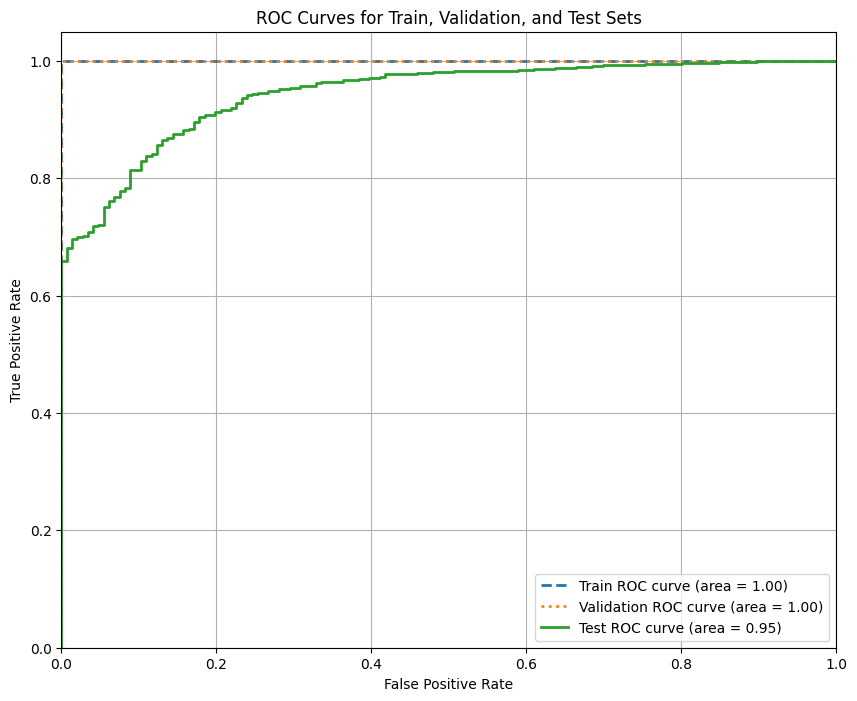

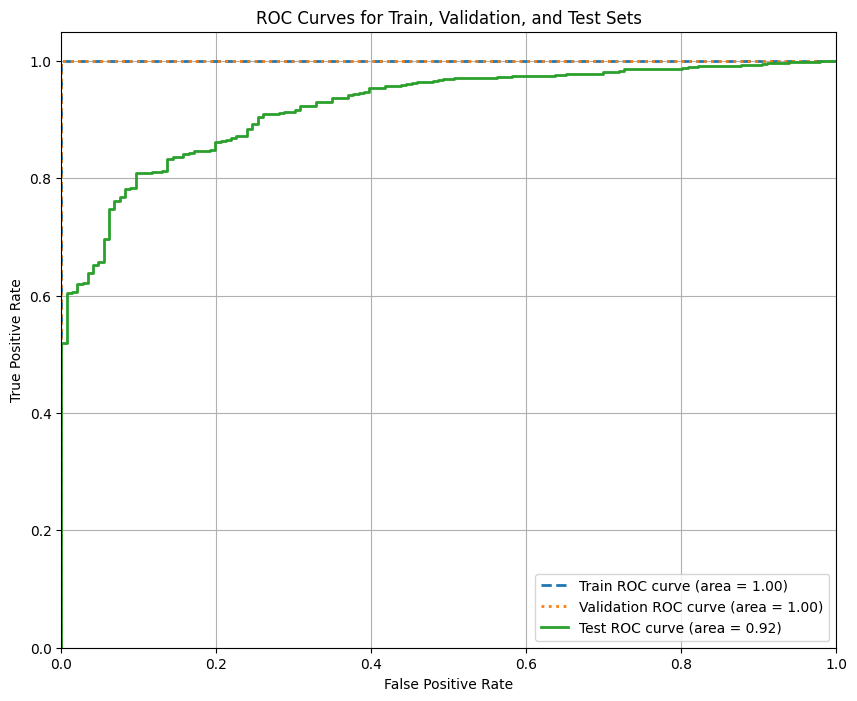

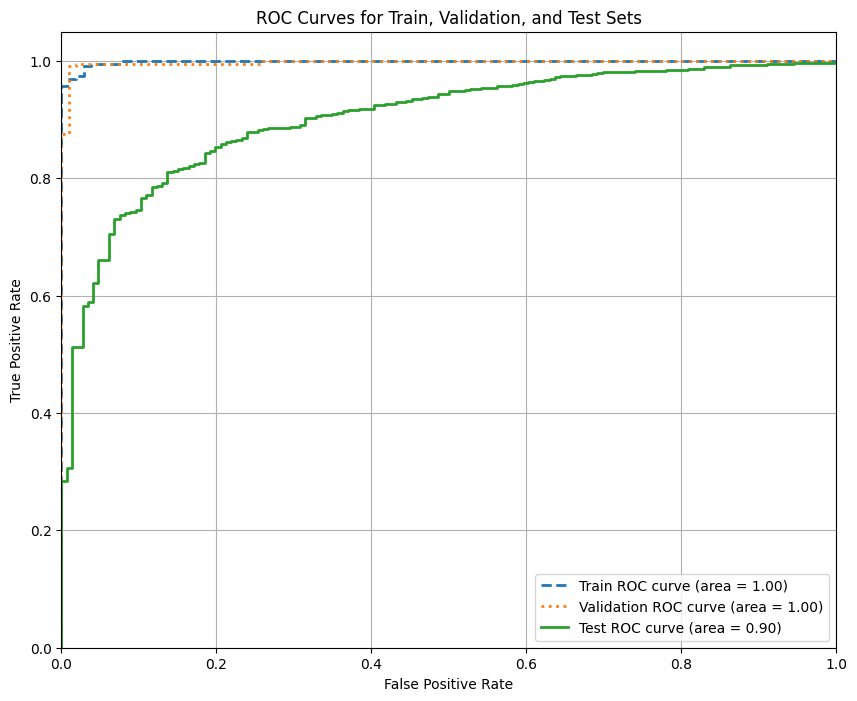

In [14]:

model_type = "LogReg"
training_pipeline(run_name,model_type,cancer_labels_dict,df,param_grid_LR,random_seed=random_seed)

 I features:  5347
Counter({'Non-small-cell lung cancer': 355, 'Asymptomatic controls': 354, 'Symptomatic_control': 307, 'Ovarian cancer': 135, 'Glioma': 132, 'Pancreatic cancer': 126, 'Head and neck cancer': 101, 'Breast cancer': 93, 'Cholangiocarcinoma': 85, 'Colorectal cancer': 84, 'Melanoma': 68, 'Endometrial cancer': 39, 'Prostate cancer': 34, 'Multiple Myeloma': 31, 'Renal cell cancer': 28, 'Urothelial cancer': 28, 'Hepatocellular carcinoma': 23, 'Lymphoma': 20, 'Esophageal carcinoma': 15})

   Random Seed                        Model Name    Model Type  \
0            7  RandomForest_2023-11-11_13-35-17  RandomForest   

                                     Best Parameters  accuracy  \
0  {'max_depth': None, 'max_features': 'sqrt', 'm...    0.5822   

        accuracy_CI  sensitivity    sensitivity_CI  specificity  \
0  [0.5534, 0.6082]       0.5177  [0.4844, 0.5468]       0.9932   

  specificity_CI      f1            f1_CI  auc_roc        auc_roc_CI  \
0  [0.9795, 1.0]  0.6818

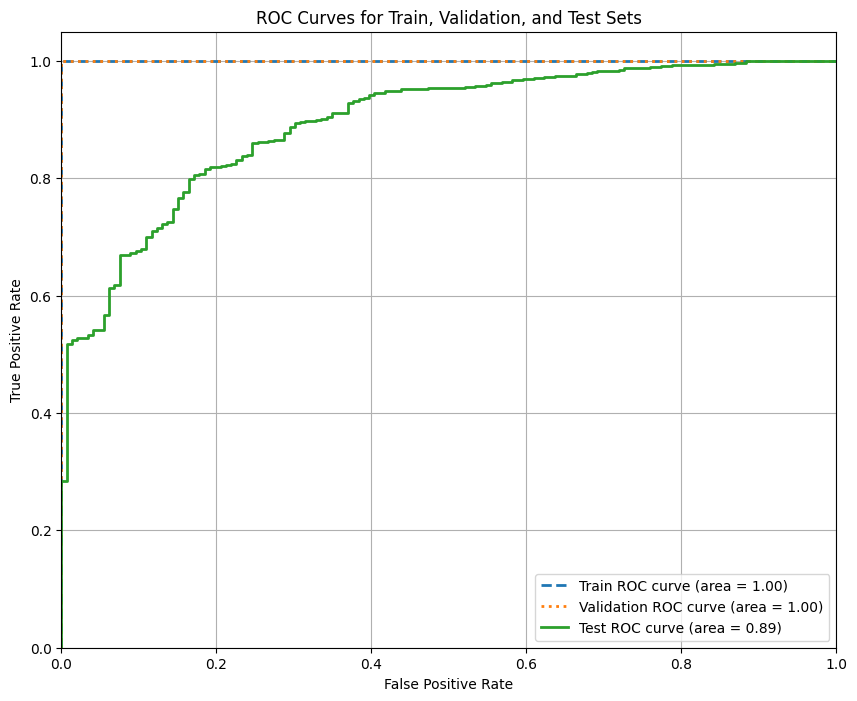

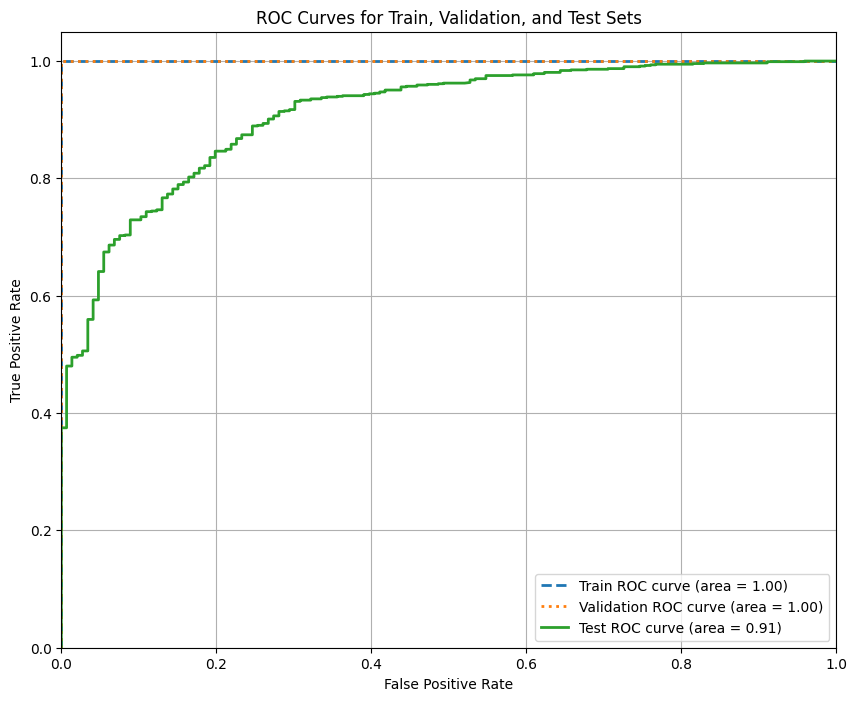

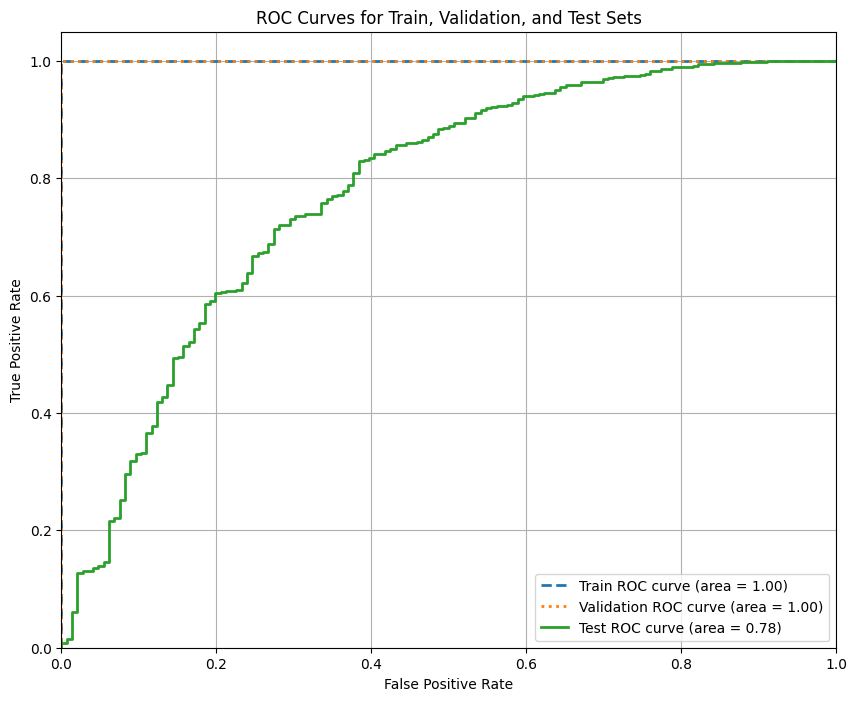

In [49]:
model_type = "RandomForest"
training_pipeline(run_name,model_type,cancer_labels_dict,df,param_grid_rf,random_seed=random_seed)

 I features:  5347
Counter({'Non-small-cell lung cancer': 355, 'Asymptomatic controls': 354, 'Symptomatic_control': 307, 'Ovarian cancer': 135, 'Glioma': 132, 'Pancreatic cancer': 126, 'Head and neck cancer': 101, 'Breast cancer': 93, 'Cholangiocarcinoma': 85, 'Colorectal cancer': 84, 'Melanoma': 68, 'Endometrial cancer': 39, 'Prostate cancer': 34, 'Multiple Myeloma': 31, 'Renal cell cancer': 28, 'Urothelial cancer': 28, 'Hepatocellular carcinoma': 23, 'Lymphoma': 20, 'Esophageal carcinoma': 15})

   Random Seed                                Model Name  \
0            7  BalancedRandomForest_2023-11-11_13-59-24   

             Model Type                                    Best Parameters  \
0  BalancedRandomForest  {'max_depth': None, 'max_features': 'sqrt', 'm...   

   accuracy       accuracy_CI  sensitivity    sensitivity_CI  specificity  \
0    0.3788  [0.3538, 0.4058]       0.2825  [0.2524, 0.3126]       0.9932   

  specificity_CI      f1             f1_CI  auc_roc        auc_r

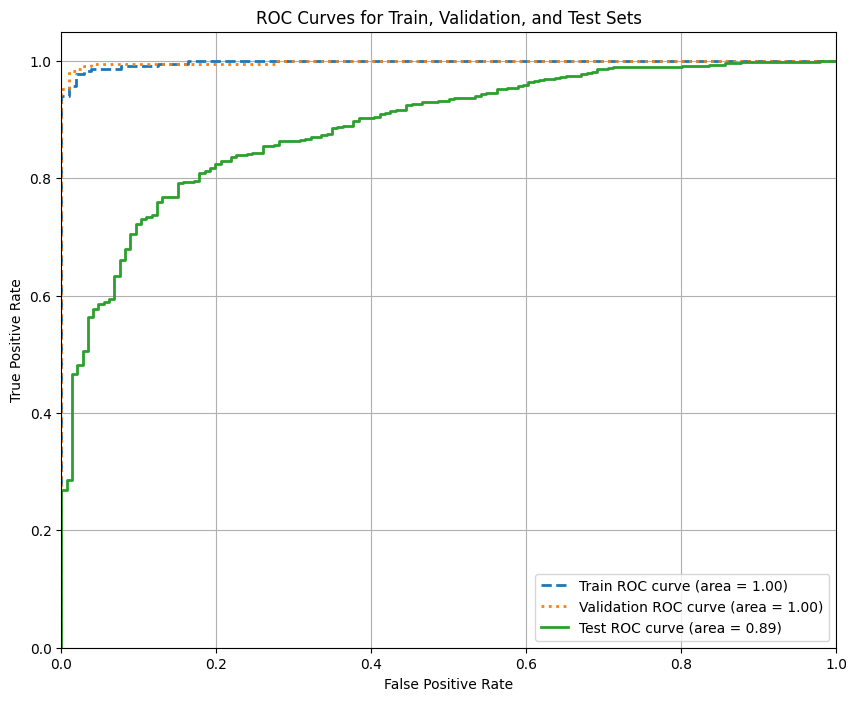

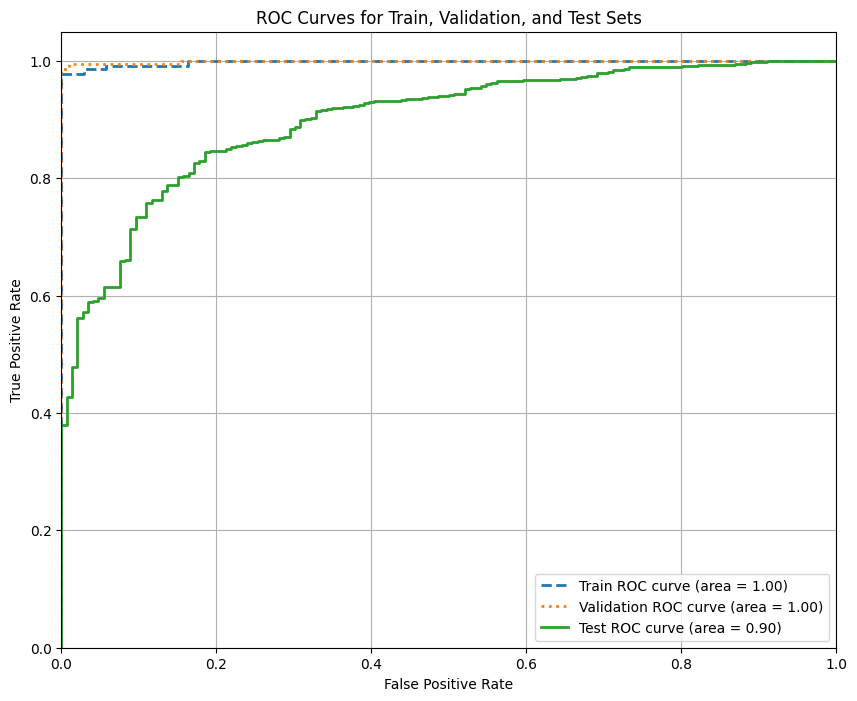

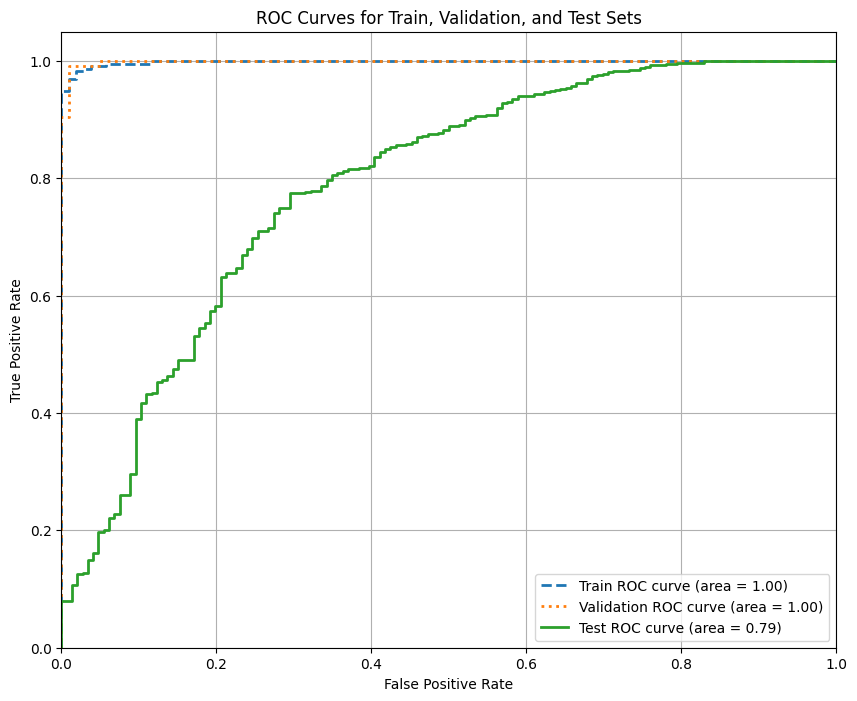

In [50]:
model_type = "BalancedRandomForest"
training_pipeline(run_name,model_type,cancer_labels_dict,df,param_grid_rf,random_seed=random_seed)

 I features:  5347
Counter({'Non-small-cell lung cancer': 355, 'Asymptomatic controls': 354, 'Symptomatic_control': 307, 'Ovarian cancer': 135, 'Glioma': 132, 'Pancreatic cancer': 126, 'Head and neck cancer': 101, 'Breast cancer': 93, 'Cholangiocarcinoma': 85, 'Colorectal cancer': 84, 'Melanoma': 68, 'Endometrial cancer': 39, 'Prostate cancer': 34, 'Multiple Myeloma': 31, 'Renal cell cancer': 28, 'Urothelial cancer': 28, 'Hepatocellular carcinoma': 23, 'Lymphoma': 20, 'Esophageal carcinoma': 15})

   Random Seed                   Model Name Model Type  \
0            7  XGBOOST_2023-11-11_14-23-07    XGBOOST   

                                     Best Parameters  accuracy  \
0  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...    0.5933   

        accuracy_CI  sensitivity    sensitivity_CI  specificity  \
0  [0.5673, 0.6202]       0.5306  [0.5016, 0.5607]       0.9932   

  specificity_CI      f1             f1_CI  auc_roc        auc_roc_CI  \
0  [0.9795, 1.0]  0.6928  [0.6667, 0.71

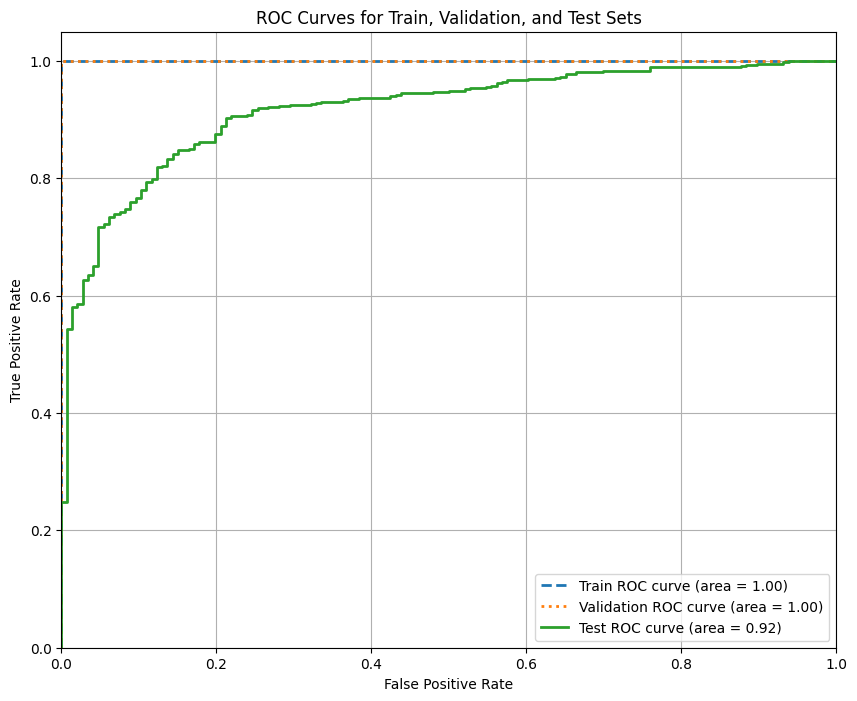

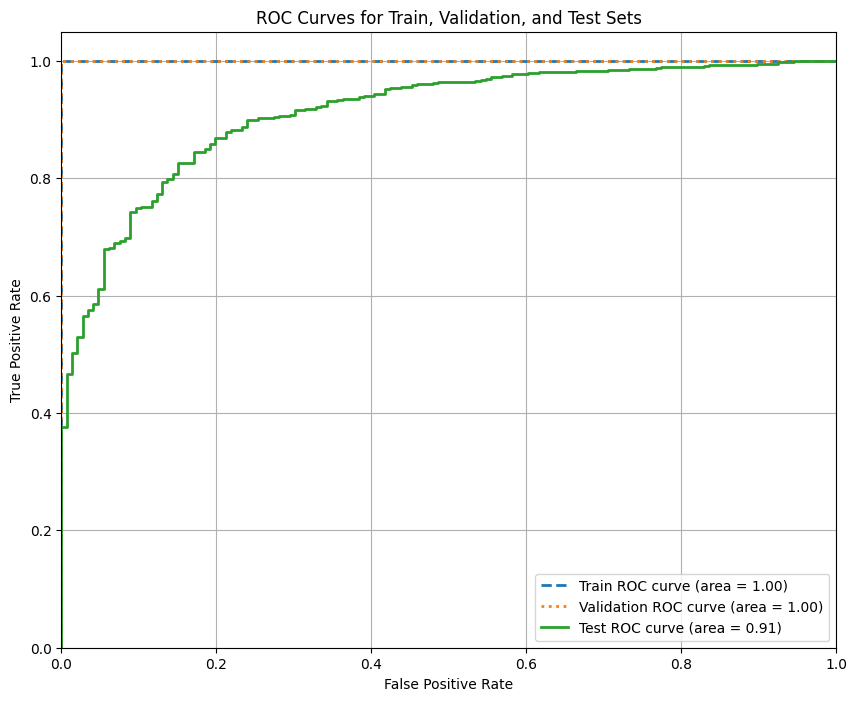

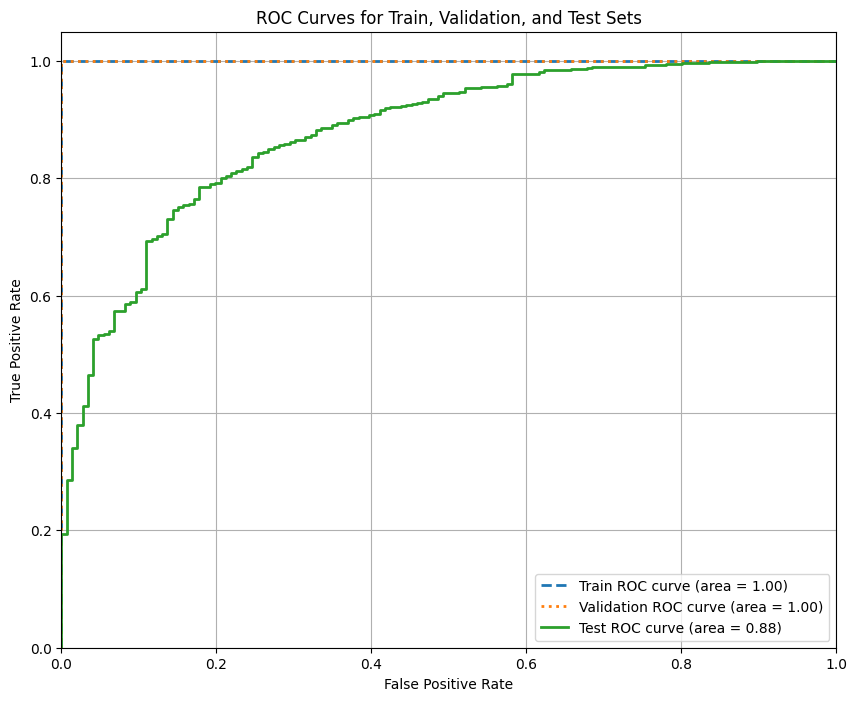

In [51]:
model_type = "XGBOOST"
training_pipeline(run_name,model_type,cancer_labels_dict,df,param_grid_xgb,random_seed=random_seed)